In [2]:
import pandas as pd
import numpy as np
import json
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot


In [3]:
# Replace with your file path
file_path = '../../../../DataInputs/Daily/AMZN.csv'

# # Load JSON data from file
# with open(file_path, 'r') as file:
#     data = json.load(file)

# Load CSV data from file
df = pd.read_csv(file_path, usecols=['Date', 'Adj Close'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.rename(columns={'Adj Close': 'Close'}, inplace=True)
df.sort_index(inplace=True)

print(df.head())


               Close
Date                
2000-01-13  3.296875
2000-01-14  3.212500
2000-01-18  3.206250
2000-01-19  3.340625
2000-01-20  3.237500


In [4]:
# Split the data into training and test sets
train_df = df[df.index <= '2023-03-31']
test_df = df[df.index >= '2023-03-31']

# Check the last date in the training set and the first date in the test set
print("Last date in training set:", train_df.index[-1])
print("First date in test set:", test_df.index[0])

# Check the last few rows of the training set
print(train_df.tail())
df = train_df.copy()
# Check the first few rows of the test set
print(test_df.head())


Last date in training set: 2023-03-31 00:00:00
First date in test set: 2023-03-31 00:00:00
                 Close
Date                  
2023-03-27   98.040001
2023-03-28   97.239998
2023-03-29  100.250000
2023-03-30  102.000000
2023-03-31  103.290001
                 Close
Date                  
2023-03-31  103.290001
2023-04-03  102.410004
2023-04-04  103.949997
2023-04-05  101.099998
2023-04-06  102.059998


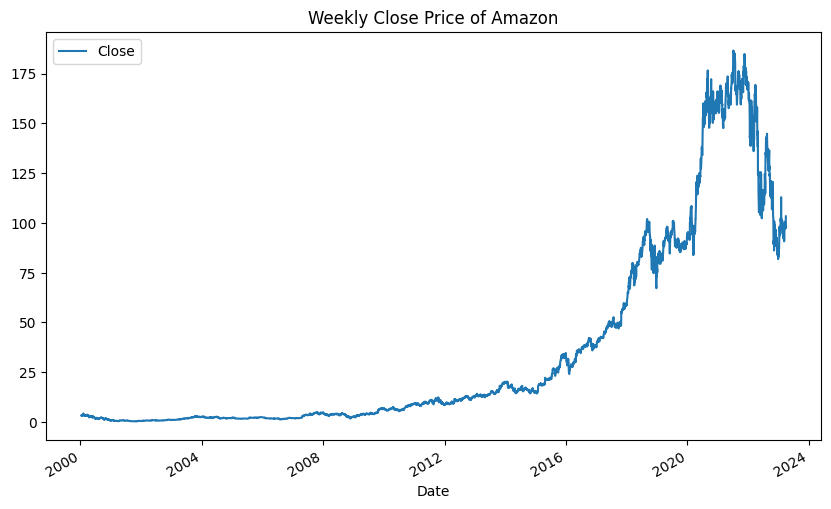

In [5]:
df.plot(figsize=(10,6))
plt.title('Weekly Close Price of Amazon')
plt.show()

In [6]:
result = adfuller(df['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# More detailed output can be shown, here we focus on p-value


ADF Statistic: -0.465650
p-value: 0.898547


In [7]:
# Assuming the series is not stationary, differencing is needed
df_diff = df.diff().dropna()

# Check stationarity again
result = adfuller(df_diff['Close'])
print('p-value after differencing: %f' % result[1])


p-value after differencing: 0.000000


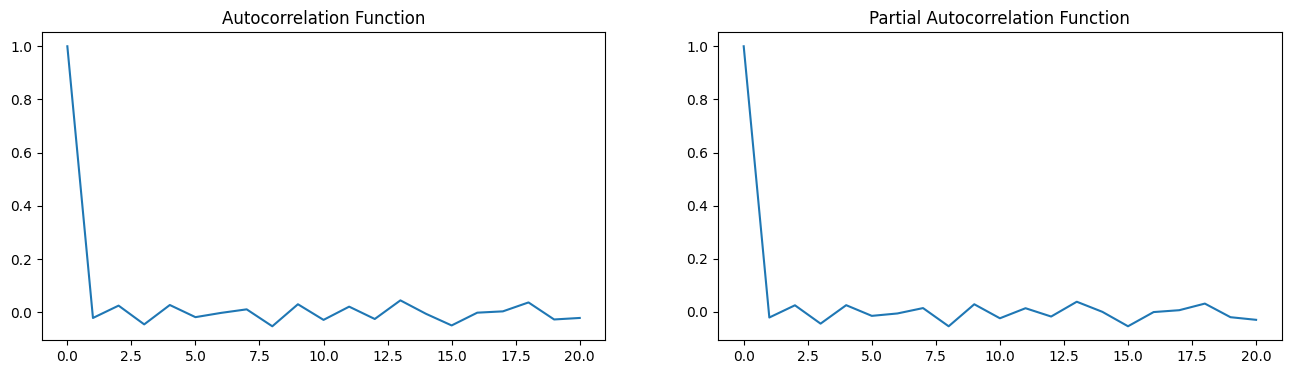

In [8]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

# ACF
acf_values = acf(df_diff['Close'], nlags=20)
ax1.plot(acf_values)
ax1.set_title('Autocorrelation Function')

# PACF
pacf_values = pacf(df_diff['Close'], nlags=20)
ax2.plot(pacf_values)
ax2.set_title('Partial Autocorrelation Function')

plt.show()


In [9]:
# Replace p, d, q with your chosen values
model = ARIMA(df['Close'], order=(0,1,0))
results = model.fit()

# Summary of the model
print(results.summary())


c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5841
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -9893.662
Date:                Sat, 13 Jan 2024   AIC                          19789.324
Time:                        14:13:16   BIC                          19795.997
Sample:                             0   HQIC                         19791.645
                               - 5841                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.7339      0.008    228.395      0.000       1.719       1.749
Ljung-Box (L1) (Q):                   2.59   Jarque-Bera (JB):            277371.25
Prob(Q):                              0.11   Pr

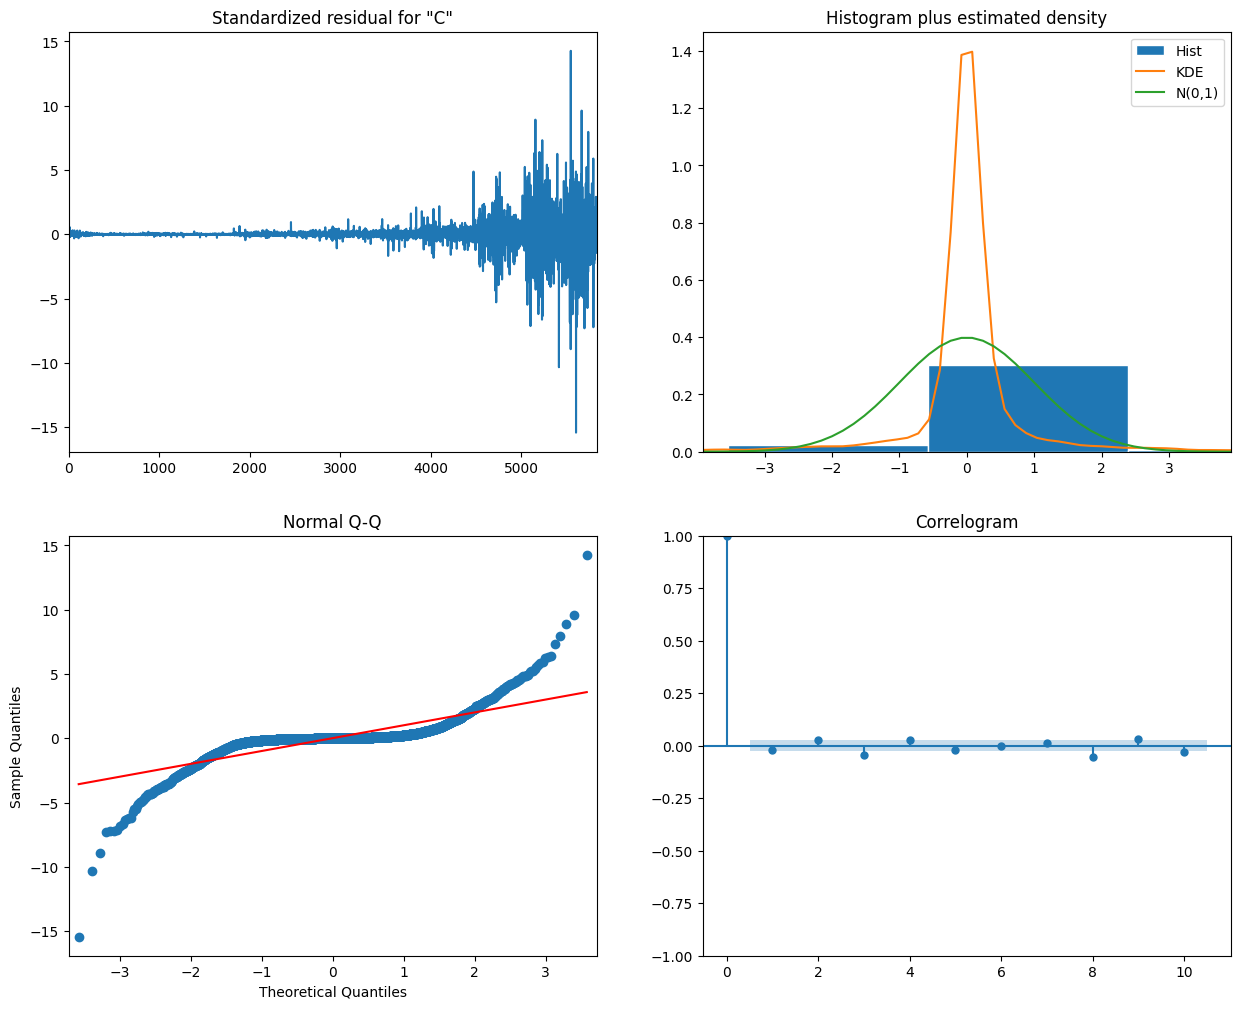

In [10]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


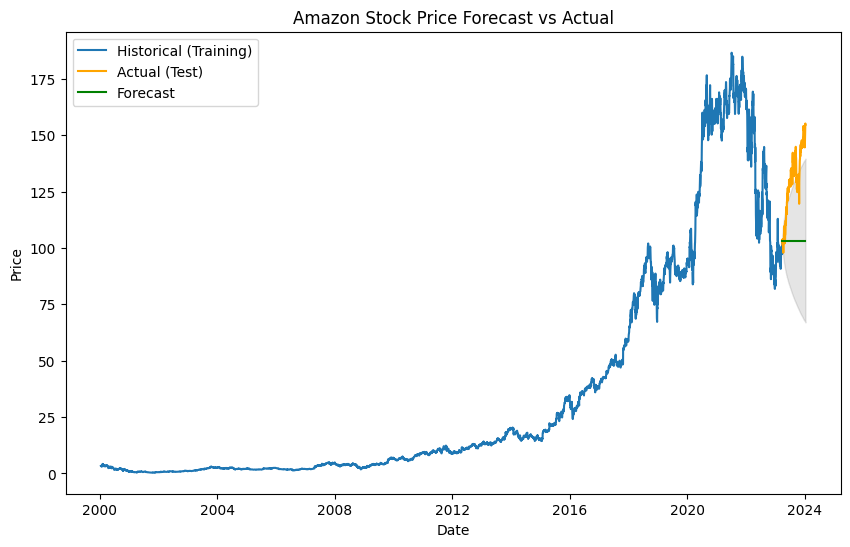

In [11]:
# Number of steps to forecast is the length of the test set
n_steps = len(test_df)

# Generate out-of-sample forecasts
forecast = results.get_forecast(steps=n_steps)
forecast_index = test_df.index  # Use the test set dates for the forecast index

# Confidence intervals
forecast_ci = forecast.conf_int()

# Plotting the forecast along with the test set
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Close'], label='Historical (Training)')
plt.plot(test_df.index, test_df['Close'], label='Actual (Test)', color='orange')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='green')
plt.fill_between(forecast_index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='k', alpha=0.1)
plt.title('Amazon Stock Price Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

predicted_values = forecast.predicted_mean
actual_values = test_df['Close']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("Root Mean Squared Error: ", rmse)

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)
print("Mean Absolute Error: ", mae)


Root Mean Squared Error:  30.67470517057387
Mean Absolute Error:  27.25252473232323


trying to make it optimal


In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Assuming best_model is your trained SARIMAX model and test_df is your test set

# Length of the test set
n_steps = len(test_df)

# Generating the forecast for n_steps
forecast, conf_int = best_model.predict(n_steps=n_steps, return_conf_int=True)

# Make sure the forecast_index aligns with the forecast length
forecast_index = test_df.index[:len(forecast)]  # Adjust in case of length mismatch

# Print the model summary
print(best_model.summary())

# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Close'], label='Historical (Training)', color='blue')
plt.plot(test_df.index, test_df['Close'], label='Actual (Test)', color='orange')
plt.plot(forecast_index, forecast, label='Forecast', color='green')

# Fill the confidence interval
plt.fill_between(forecast_index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], color='grey', alpha=0.3)

# Zoom in to the graph starting from July 2023
plt.xlim([pd.Timestamp('2023-01-01'), forecast_index[-1]])

# Set the title and labels
plt.title('Optimized SARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')

# Set the date format for the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Rotate the date labels for better readability
plt.gcf().autofmt_xdate()

# Add the legend
plt.legend()

# Show the plot
plt.show()


NameError: name 'best_model' is not defined

In [19]:
import pmdarima as pm

# Using auto_arima to find the best ARIMA model with a wider range of parameters
best_model = pm.auto_arima(train_df['Close'],
                           seasonal=True,  # assuming the data could be seasonal
                           m=5,           # weekly data, so m might be 52 for yearly seasonality
                           stepwise=True,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           max_p=5, max_q=5, max_d=2,
                           max_P=3, max_Q=3, max_D=3)

print(best_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=19754.021, Time=19.84 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=19790.337, Time=0.18 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=19789.952, Time=0.96 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=19789.955, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=19789.324, Time=0.23 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=19728.925, Time=15.24 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=19726.925, Time=7.85 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=19728.925, Time=14.60 sec
 ARIMA(1,1,2)(0,0,0)[5] intercept   : AIC=19780.673, Time=3.25 sec
 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=19781.070, Time=2.87 sec
 ARIMA(3,1,2)(0,0,0)[5] intercept   : AIC=19727.833, Time=11.90 sec
 ARIMA(2,1,3)(0,0,0)[5] intercept   : AIC=19727.849, Time=11.73 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=19782.488, Time=2.48 sec
 ARIMA(1,1,3)(0,0,0)[5] intercept   : AIC=19775.865, Time=3.07 sec
 ARIMA(3,1,1)(

c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


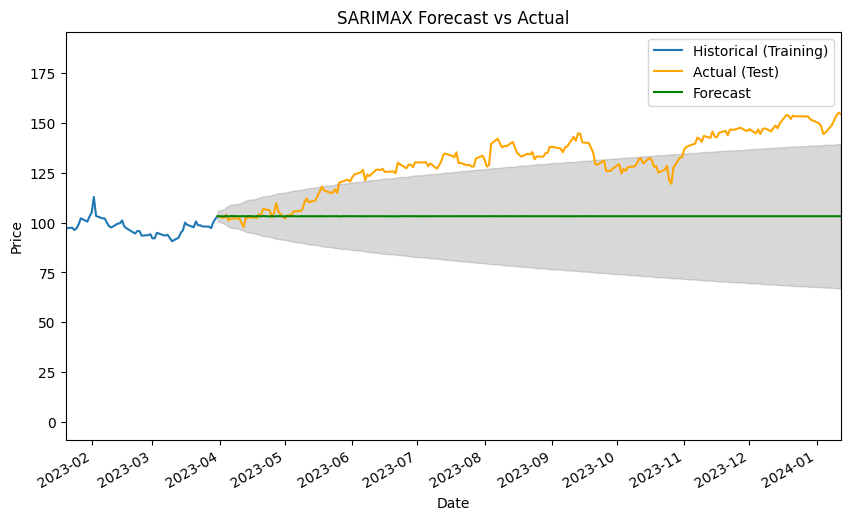

In [23]:
# Forecast with the best SARIMAX model
n_periods = len(test_df)
forecast, conf_int = best_model.predict(n_periods=n_periods, return_conf_int=True)

# Plot the forecast with confidence intervals
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Close'], label='Historical (Training)')
plt.plot(test_df.index, test_df['Close'], label='Actual (Test)', color='orange')
plt.plot(test_df.index, forecast, label='Forecast', color='green')
plt.fill_between(test_df.index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], color='grey', alpha=0.3)

# Set the xlim to show data from July 2023 onwards
plt.xlim([pd.Timestamp('2023-01-20'), test_df.index[-1]])

# (Optional) Set the format of the x-axis to better display the dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.title('SARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the date labels for better readability
plt.gcf().autofmt_xdate()

plt.show()


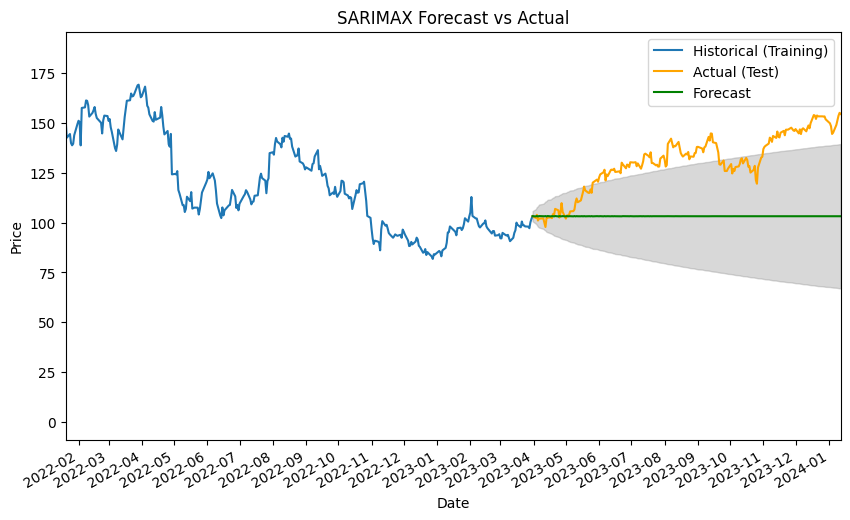

In [21]:
import matplotlib.dates as mdates

# Plot the forecast with confidence intervals
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Close'], label='Historical (Training)')
plt.plot(test_df.index, test_df['Close'], label='Actual (Test)', color='orange')
plt.plot(test_df.index, forecast, label='Forecast', color='green')
plt.fill_between(test_df.index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], color='grey', alpha=0.3)

# Set the xlim to show data from July 2023 onwards
plt.xlim([pd.Timestamp('2022-01-20'), test_df.index[-1]])

# (Optional) Set the format of the x-axis to better display the dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.title('SARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the date labels for better readability
plt.gcf().autofmt_xdate()

plt.show()


In [22]:
# Generating the forecast for the entire duration of the test set
forecast, conf_int = best_model.predict(n_periods=n_steps, return_conf_int=True)

# Make sure the forecast_index aligns with the forecast length
# This should be equivalent to the test set index length
forecast_index = test_df.index

# Now the predicted_values should have the same length as the actual_values
predicted_values = forecast

# Actual values from the test set
actual_values = test_df['Close']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("Root Mean Squared Error: ", rmse)

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)
print("Mean Absolute Error: ", mae)


Root Mean Squared Error:  30.708372621099024
Mean Absolute Error:  27.284375347779868


c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
